# Model

## Libs

In [66]:
from dateutil.relativedelta import relativedelta
import os
from sqlalchemy import create_engine, inspect
import pandas as pd
import matplotlib.pyplot as plt

## Data

In [40]:
def calcular_meses(periodo):
    try:
        if pd.isna(periodo):
            return None

        # Remove quebras de linha e espaços extras
        periodo = periodo.replace("\n", "").strip()

        # Padroniza separadores estranhos para hífen simples
        periodo = periodo.replace("–", "-").replace("—", "-")

        partes = periodo.split("-")
        if len(partes) != 2:
            return None

        inicio_str = partes[0].strip()
        fim_str = partes[1].strip()

        # Converte strings para datetime
        inicio = pd.to_datetime(inicio_str, format="%m/%Y", errors='coerce')
        fim = pd.to_datetime(fim_str, format="%m/%Y", errors='coerce')

        if pd.isnull(inicio) or pd.isnull(fim):
            return None

        # Calcula a diferença em meses e transforma em valor absoluto
        diff = relativedelta(fim, inicio)
        meses = diff.years * 12 + diff.months + 1

        return abs(meses)
    
    except Exception as e:
        print(f"Erro ao processar período '{periodo}': {e}")
        return None

In [ ]:
caminho_db = os.path.abspath("../data/sql/applicants.db")

engine = create_engine(f"sqlite:///{caminho_db}")
inspector = inspect(engine)
print("Tabelas disponíveis:", inspector.get_table_names())



Tabelas disponíveis: ['basic_info', 'cv_content', 'education_languages', 'personal_info', 'professional_experience', 'professional_info']


In [15]:
query = "SELECT * FROM basic_info"
df_basic_info = pd.read_sql(query, engine)
query = "SELECT * FROM cv_content"
df_cv_content = pd.read_sql(query, engine)
query = "SELECT * FROM education_languages"
df_education_languages = pd.read_sql(query, engine)
query = "SELECT * FROM personal_info"
df_personal_info = pd.read_sql(query, engine)
query = "SELECT * FROM professional_experience"
df_professional_experience = pd.read_sql(query, engine)
query = "SELECT * FROM professional_info"
df_professional_info = pd.read_sql(query, engine)

In [84]:
#df_basic_info.head()
#df_cv_content.head()
#df_education_languages.head()
#df_personal_info.head()
#df_professional_experience.head()
df_professional_info.head()

,codigo_profissional,titulo_profissional,area_atuacao,conhecimentos_tecnicos,certificacoes,outras_certificacoes,remuneracao,nivel_profissional
0,31000,,,,,,,
1,31001,Analista Administrativo,Administrativa,,,,1900,
2,31002,Administrativo | Financeiro,Administrativa,,"MS [77-418] MOS: Microsoft Office Word 2013, M...",,"2.500,00",
3,31003,Área administrativa,Administrativa,,,,"1100,00",
4,31004,,,,,,,


In [19]:
# Investigando os dados
df_basic_info.sabendo_de_nos_por = df_basic_info.sabendo_de_nos_por.fillna("Não informado")
df_basic_info.sabendo_de_nos_por = df_basic_info.sabendo_de_nos_por.str.replace(" ", "_")
df_basic_info.sabendo_de_nos_por.aggregate(lambda x: x.value_counts())


sabendo_de_nos_por
                            22106
Outros                      15197
Site_de_Empregos             1841
Indeed                       1175
Anúncio                       767
Indicação_de_amigo            515
Nosso_site                    432
Indicação_de_colaborador      318
Indicação_de_cliente          100
Escolas/Faculdades             12
Feira_de_RH                     9
ONG/PAT/CAT                     4
Evento_universitário            3
Plaqueiro                       3
Name: count, dtype: int64

In [76]:
df_professional_experience['tempo_meses'] = df_professional_experience['periodo'].apply(calcular_meses).fillna(0).astype(int)
df_professional_experience.loc[(df_professional_experience['tempo_meses'] > 400), 'tempo_meses'] = 0
df_professional_experience['tempo_meses'].describe()

count    11730.000000
mean        21.912276
std         26.911156
min          0.000000
25%          7.000000
50%         13.000000
75%         26.000000
max        400.000000
Name: tempo_meses, dtype: float64

In [79]:
# Converte a coluna para datetime, com tratamento de erros
df_personal_info['data_nascimento'] = pd.to_datetime(df_personal_info['data_nascimento'], format='%d/%m/%Y', errors='coerce')

# Calcula a idade apenas para datas válidas
hoje = pd.to_datetime("today")
df_personal_info['idade_anos'] = df_personal_info['data_nascimento'].apply(
    lambda x: hoje.year - x.year if pd.notnull(x) else None
)

# Preenche valores nulos com 0 e transforma em int
df_personal_info['idade_anos'] = df_personal_info['idade_anos'].fillna(0).astype(int)
df_personal_info.loc[(df_personal_info['idade_anos'] > 100) | (df_personal_info['idade_anos'] < 18), 'idade_anos'] = 0


<Axes: title={'center': 'Distribuição de Idade dos Candidatos'}, xlabel='idade_anos'>

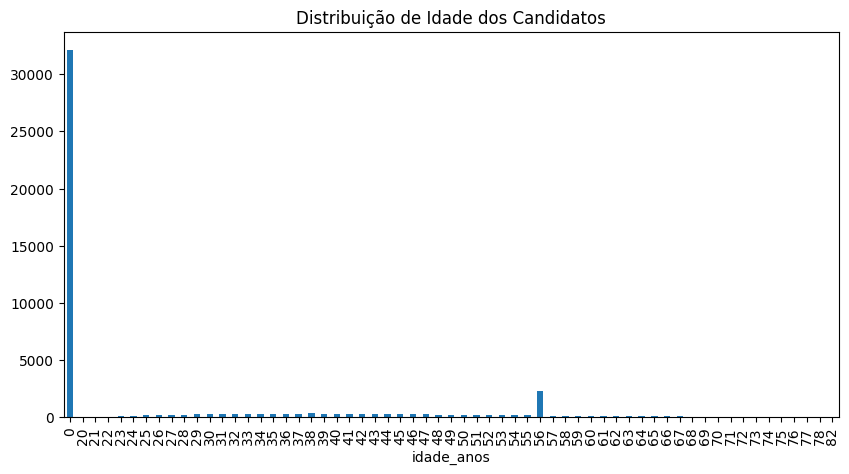

In [90]:
#df_personal_info['idade_anos'].unique()
df_personal_info['idade_anos'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5), title="Distribuição de Idade dos Candidatos")

#### Conclusões
não utilizar idade, já que a maioria vai zerar,

In [82]:
df_personal_info['idade_anos'].describe()

count    42482.000000
mean        10.925121
std         20.032589
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         82.000000
Name: idade_anos, dtype: float64

## Data Pre Processor

In [97]:
#Ajustando dados em apenas um Dataframe para aplicar ao modelo
df_analise = df_basic_info[['codigo_profissional', 'nome', 'email', 'telefone']]
df_education_languages_selected = df_education_languages[['codigo_profissional', 'nivel_academico', 'nivel_ingles','nivel_espanhol']]
df_personal_info_selected = df_personal_info[['codigo_profissional', 'idade_anos', 'sexo', 'estado_civil']]
df_professional_info_selected = df_professional_info[['codigo_profissional', 'remuneracao']]

# Realizando os merges com as colunas selecionadas
df_analise = df_analise.merge(df_education_languages_selected, on='codigo_profissional', how='left')
df_analise = df_analise.merge(df_personal_info_selected, on='codigo_profissional', how='left')
df_analise = df_analise.merge(df_professional_info_selected, on='codigo_profissional', how='left')

In [98]:
# Calcula a média de tempo_meses por codigo_profissional
df_professional_experience_avg = df_professional_experience.groupby('codigo_profissional', as_index=False)['tempo_meses'].mean()

# Renomeia a coluna para indicar que é a média
df_professional_experience_avg.rename(columns={'tempo_meses': 'media_tempo_meses'}, inplace=True)

# Realiza o merge com a média de tempo_meses
df_analise = df_analise.merge(df_professional_experience_avg, on='codigo_profissional', how='left')

In [99]:
df_analise


,codigo_profissional,nome,email,telefone,nivel_academico,nivel_ingles,nivel_espanhol,idade_anos,sexo,estado_civil,remuneracao,media_tempo_meses
0,31000,Carolina Aparecida,carolina_aparecida@gmail.com,(11) 97048-2708,,,,0,,,NaN,14.0
1,31001,Eduardo Rios,eduardo_rios@hotmail.com,(11) 93723-4396,Ensino Superior Incompleto,Nenhum,Nenhum,31,Feminino,Solteiro,1900.0,NaN
2,31002,Pedro Henrique Carvalho,pedro_henrique_carvalho@gmail.com,(11) 92399-9824,Ensino Superior Completo,Intermediário,Básico,37,Feminino,Solteiro,2500.0,NaN
3,31003,Thiago Barbosa,thiago_barbosa@hotmail.com,(11) 98100-1727,Ensino Superior Incompleto,Nenhum,Nenhum,33,Feminino,Casado,1100.0,NaN
4,31004,Diogo das Neves,diogo_das_neves@hotmail.com,(11) 92517-2678,,,,56,,,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
42477,5995,Gabrielly Novaes,gabrielly_novaes@gmail.com,(11) 92622-2088,,,,0,,,0.0,NaN
42478,5996,Sr. Gabriel Rios,sr._gabriel_rios@gmail.com,(41) 93009-5141,,,,0,,,0.0,NaN
42479,5997,Dr. Mathias da Cunha,dr._mathias_da_cunha@gmail.com,(11) 97837-3941,,,,0,,,0.0,NaN
42480,5998,Bruna Vieira,bruna_vieira@hotmail.com,(61) 96806-8075,,,,0,,,0.0,NaN


In [105]:
# Contar valores nulos, vazios e zero
null_or_empty_count = df_analise.isnull().sum() + (df_analise == "").sum() + (df_analise == 0).sum()

# Exibir o resultado
print(null_or_empty_count)

codigo_profissional        0
nome                       0
email                      0
telefone                1456
nivel_academico        34388
nivel_ingles           35638
nivel_espanhol         35795
idade_anos             32119
sexo                   35298
estado_civil           35031
remuneracao            37388
media_tempo_meses      39771
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Preenchendo valores nulos
df_analise['remuneracao'] = df_analise['remuneracao'].fillna(0)
df_analise['media_tempo_meses'] = df_analise['media_tempo_meses'].fillna(0)
df_analise['nivel_academico'] = df_analise['nivel_academico'].fillna('Desconhecido')
df_analise['nivel_ingles'] = df_analise['nivel_ingles'].fillna('Desconhecido')
df_analise['nivel_espanhol'] = df_analise['nivel_espanhol'].fillna('Desconhecido')
df_analise['sexo'] = df_analise['sexo'].fillna('Desconhecido')
df_analise['estado_civil'] = df_analise['estado_civil'].fillna('Desconhecido')

# Codificando variáveis categóricas
label_encoders = {}
categorical_columns = ['nivel_academico', 'nivel_ingles', 'nivel_espanhol', 'sexo', 'estado_civil']

for col in categorical_columns:
    le = LabelEncoder()
    df_analise[col] = le.fit_transform(df_analise[col])
    label_encoders[col] = le

# Definindo as features (X) e o target (y)
X = df_analise.drop(columns=['codigo_profissional', 'nome', 'email', 'telefone'])
y = (df_analise['remuneracao'] > 0).astype(int)  # Exemplo: target binário baseado em remuneração

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando o modelo de Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


Modelo treinado com sucesso!


In [107]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Fazendo previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calculando métricas de avaliação
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Exibindo os resultados
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusão:")
print(conf_matrix)

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Acurácia: 1.00
Precisão: 1.00
Recall: 1.00
F1-Score: 1.00

Matriz de Confusão:
[[7476    0]
 [   0 1021]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7476
           1       1.00      1.00      1.00      1021

    accuracy                           1.00      8497
   macro avg       1.00      1.00      1.00      8497
weighted avg       1.00      1.00      1.00      8497



## Model

## Train

## Predict

## Metrics